In [1]:
import pvdeg
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Create Scenario and Populate Location
The default geospatial datapoints for addLocation are from the Americas satellite. This is the only data we are interested in for this case so don't specify any location arguments.
To speed up calculations we will downsample to get coarser data. The downsampling function is not linear. A downsample factor of 10 takes us from 2018267 entries to only 5109.

In [2]:
features = pvdeg.scenario.GeospatialScenario(
    name='finding-features'
)

features.addLocation(downsample_factor=10)

/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


## Intro to KDTrees

A K dimensional tree is a datastructure for organizing n points in a k dimensional space. They are often used for nearest neighbors searches and many ML algorithms. Letting k = 2, our dimensions will be latitude and longitude. This is much faster than iterating over tabular data structures to find neighbors. The function to create a kdtree below requires scikit learn (also known as sklearn), a python machine learning library which is not included in the pvdeg dependency list so you will have to install it independently. Scipy also has a kdtree class but it is much slower. Depending on the number of datapoints the tree build time could be quite long but for our purposes, the cell below will be quick.

In [3]:
tree = pvdeg.geospatial.meta_KDtree(meta_df=features.meta_data)

## Remaining Points After Downsampling

Text(0.5, 1.0, 'Downsampled Points')

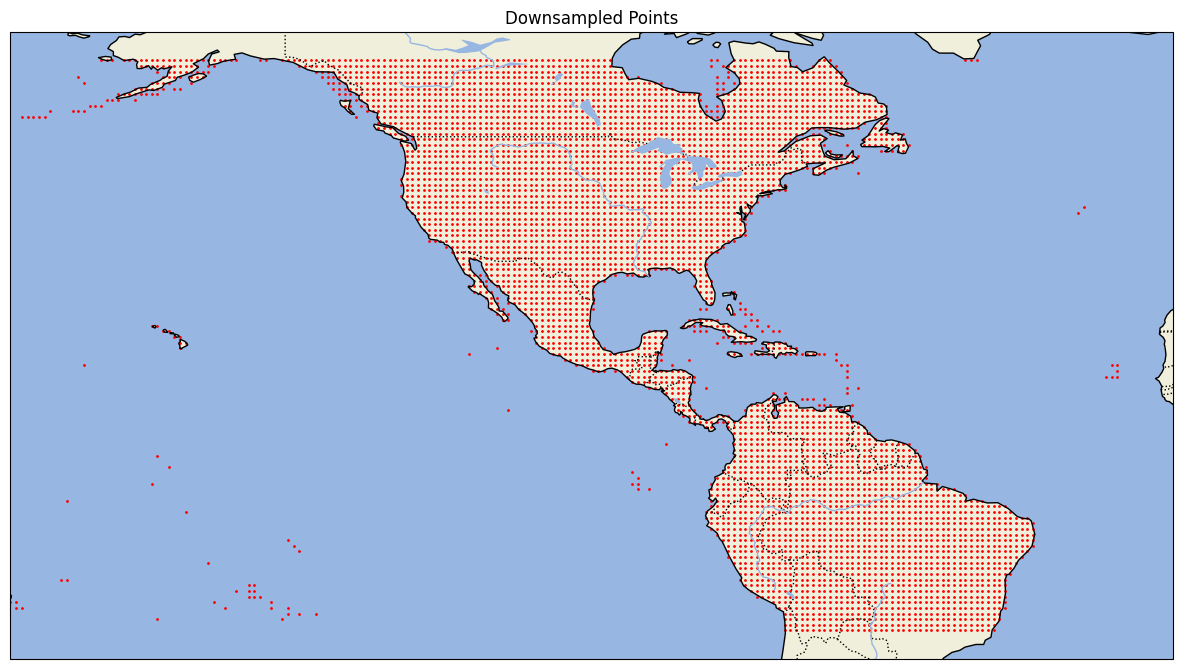

In [4]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

ax.scatter(features.meta_data['longitude'], features.meta_data['latitude'], s=1, color='red',transform=ccrs.PlateCarree())

plt.title('Downsampled Points')

## Identifying Mountains from Geospatial Data

identify moutains by using the function below. The search radii can be fine tuned for your use case. Currently the function has issues recognizing mountains near the coastline. 

In [5]:
mountains_df = pvdeg.geospatial.identify_mountains(
    meta_df=features.meta_data,
    kdtree=tree,
    elevation_floor=0
)

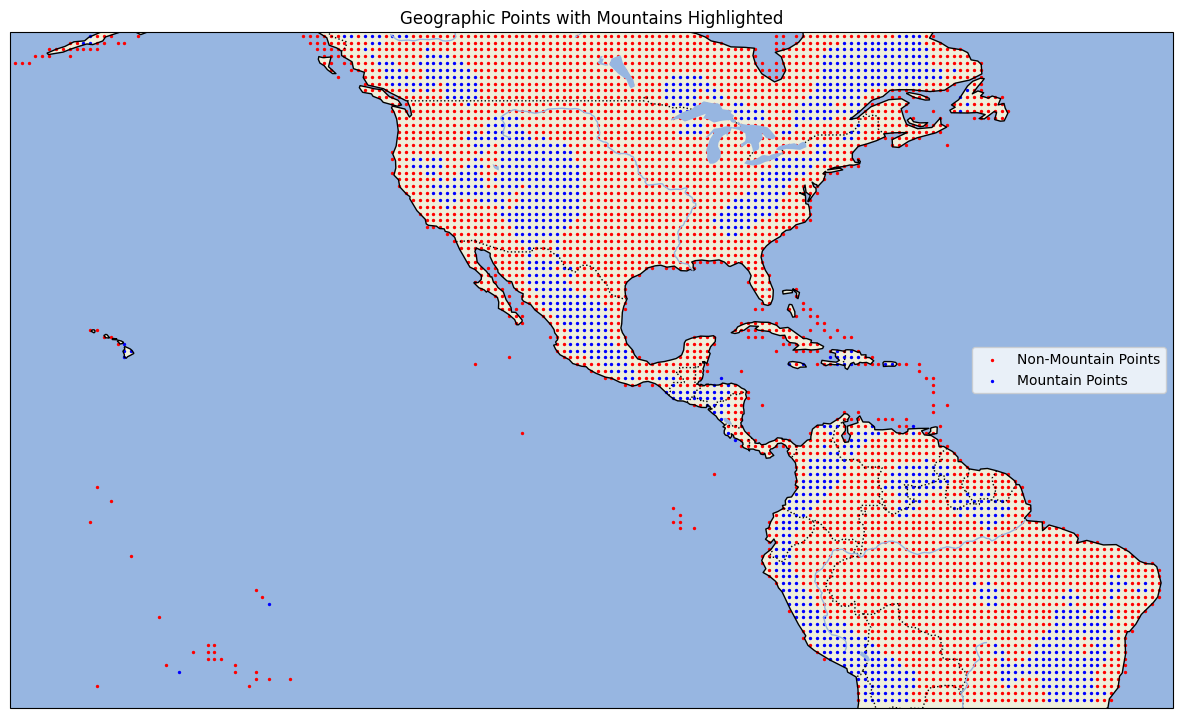

In [6]:
# Separate the meta_sub into mountains and non-mountains
mountains = mountains_df[mountains_df['mountain'] == True]
non_mountains = mountains_df[mountains_df['mountain'] == False]

# Plotting with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

top_left = [57.041016, -169.277344]
bottom_right = [-21.972656, -33.398438]

ax.set_xlim([top_left[1], bottom_right[1]])  
ax.set_ylim([bottom_right[0], top_left[0]])  

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot non-mountain points in red with smaller size
ax.scatter(non_mountains['longitude'], non_mountains['latitude'], color='red', s=2, transform=ccrs.PlateCarree(), label='Non-Mountain Points')

# Plot mountain points in blue with smaller size
ax.scatter(mountains['longitude'], mountains['latitude'], color='blue', s=2, transform=ccrs.PlateCarree(), label='Mountain Points')

# Set title and legend
plt.title('Geographic Points with Mountains Highlighted')
plt.legend()

# Show the plot
plt.show()

## Identifying mountains within a bounding box.

Sometimes we only want information from one area. To allow for more control over the selection process. To pick only one area from an existing superset of data we can use a bounding box. 
Either provide the top left and bottom right (latitude-longitude) pairs or a 2d numpy array of these pairs which will use the most extreme entries to form the bounding box.

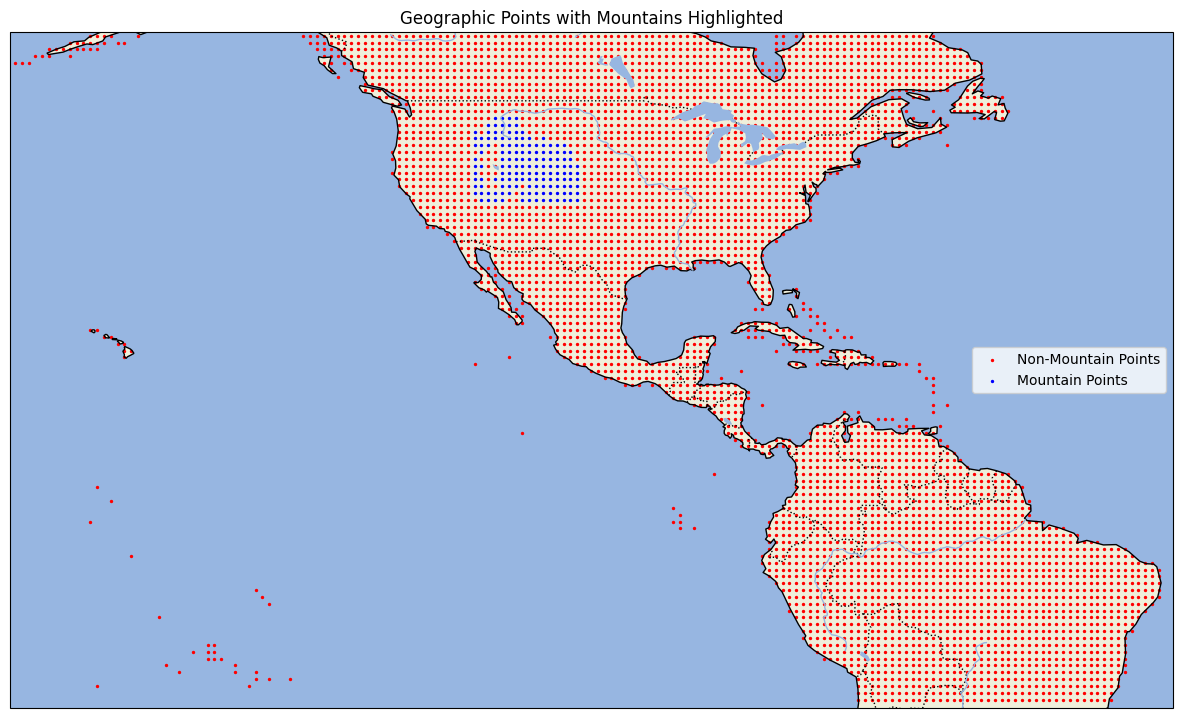

In [7]:
mountains_df = pvdeg.geospatial.identify_mountains(
    meta_df=features.meta_data,
    kdtree=tree,
    elevation_floor=0,
    bbox_kwarg={'coords' : np.array([
    [47.960502, -115.048828],
    [47.842658, -101.118164],
    [36.738884, -113.686523],
    [36.633162, -100.283203],
    ])}
)

mountains = mountains_df[mountains_df['mountain'] == True]
non_mountains = mountains_df[mountains_df['mountain'] == False]

# Plotting with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_xlim([top_left[1], bottom_right[1]])  
ax.set_ylim([bottom_right[0], top_left[0]])  

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot non-mountain points in red with smaller size
ax.scatter(non_mountains['longitude'], non_mountains['latitude'], color='red', s=2, transform=ccrs.PlateCarree(), label='Non-Mountain Points')

# Plot mountain points in blue with smaller size
ax.scatter(mountains['longitude'], mountains['latitude'], color='blue', s=2, transform=ccrs.PlateCarree(), label='Mountain Points')

# Set title and legend
plt.title('Geographic Points with Mountains Highlighted')
plt.legend()

# Show the plot
plt.show()

## Identifying Coastlines from Geospatial Data

To identify points within a search radius of any [natural earth features](https://www.naturalearthdata.com/features/). The following examples show the process of identifying coastline and river datapoints.

In [13]:
coast_df = pvdeg.geospatial.feature_downselect(
    meta_df=features.meta_data,
    kdtree=tree,
    feature_name='coastline',
    resolution='10m',
    radius=0.2 # change this to get a wider band of selected data near the coastline
)

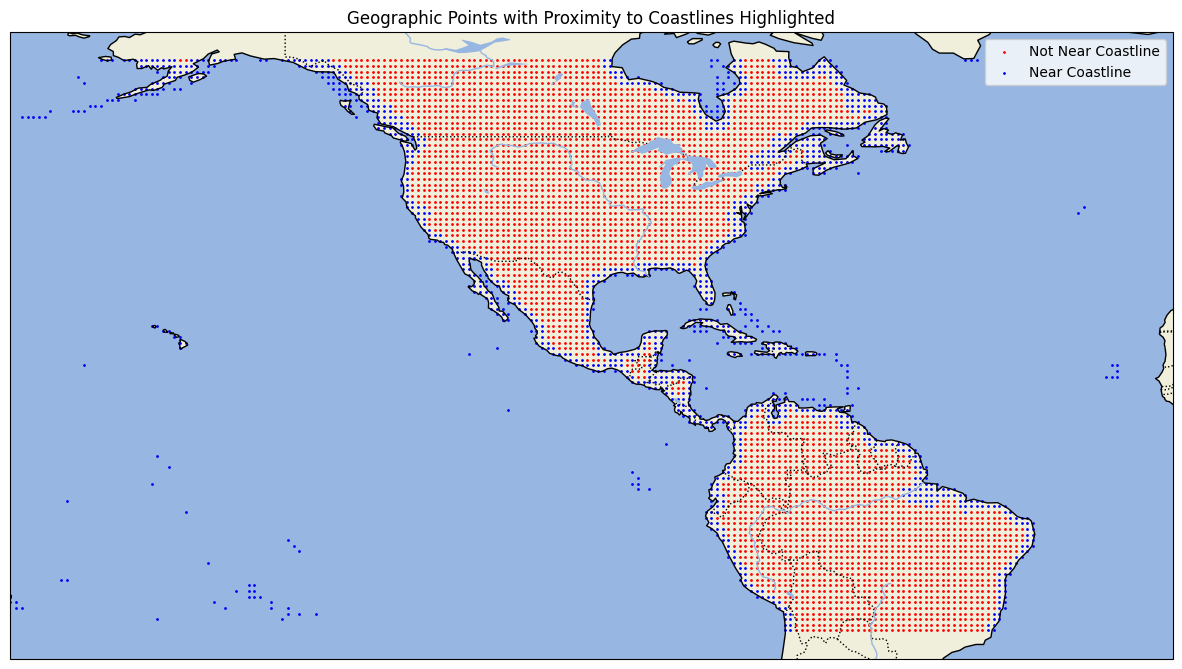

In [11]:
near_coastline = coast_df[coast_df['coastline'] == True]
not_near_coastline = coast_df[coast_df['coastline'] == False]

# Plotting with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot points not near the coastline in red with smaller size
ax.scatter(not_near_coastline['longitude'], not_near_coastline['latitude'], color='red', s=1, transform=ccrs.PlateCarree(), label='Not Near Coastline')

# Plot points near the coastline in blue with smaller size
ax.scatter(near_coastline['longitude'], near_coastline['latitude'], color='blue', s=1, transform=ccrs.PlateCarree(), label='Near Coastline')

# Set title and legend
plt.title('Geographic Points with Proximity to Coastlines Highlighted')
plt.legend()

# Show the plot
plt.show()

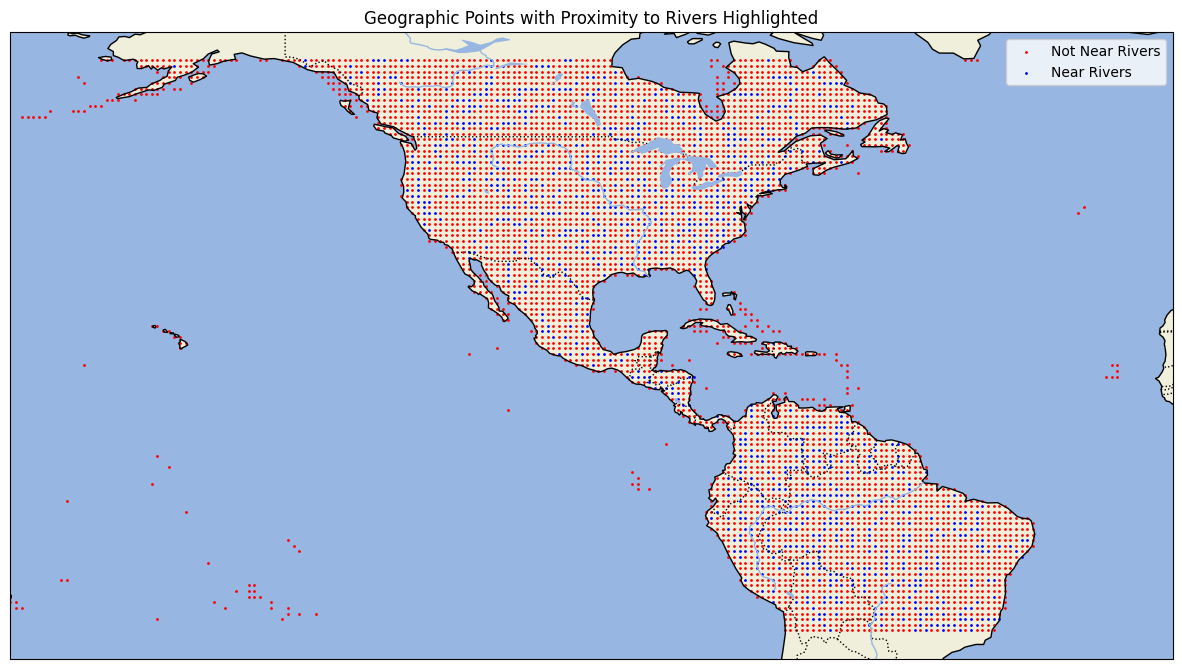

In [21]:
rivers_df = pvdeg.geospatial.feature_downselect(
    meta_df=features.meta_data,
    kdtree=tree,
    feature_name='rivers_lake_centerlines',
    resolution='10m',
    radius=0.2
)

near_river = rivers_df[rivers_df['rivers_lake_centerlines'] == True]
not_near_river = rivers_df[rivers_df['rivers_lake_centerlines'] == False]

# Plotting with Cartopy
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot points not near the coastline in red with smaller size
ax.scatter(not_near_river['longitude'], not_near_river['latitude'], color='red', s=1, transform=ccrs.PlateCarree(), label='Not Near Rivers')

# Plot points near the coastline in blue with smaller size
ax.scatter(near_river['longitude'], near_river['latitude'], color='blue', s=1, transform=ccrs.PlateCarree(), label='Near Rivers')

# Set title and legend
plt.title('Geographic Points with Proximity to Rivers Highlighted')
plt.legend()

# Show the plot
plt.show()